# 06. Model Performance Analysis (The Scouts)

**Objective:** Analyze the operational efficiency and reasoning characteristics of the individual VLM Scouts (Qwen, Kimi, Gemma).

**Input:** `output/logs_*.jsonl` (Generated by `src/main.py`)
**Output:** Statistical tables and figures for the **"Experiments"** section of the paper.

### Key Metrics Analyzed:
1.  **Latency Breakdown:** Symbolic (YOLO) vs. Cognitive (VLM) time.
2.  **Token Economics:** Input Context vs. Reasoning Depth (Output Tokens).
3.  **Throughput:** Tokens Per Second (TPS) on local hardware.
4.  **Risk Distribution:** How "alarmist" is each model?

In [5]:
import pandas as pd
import json
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set Publication Style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['savefig.dpi'] = 300

# Define Color Palette for Models
MODEL_PALETTE = {
    "Qwen3-VL": "#1f77b4",  # Blue
    "Kimi-VL": "#2ca02c",   # Green
    "Gemma-3": "#ff7f0e"    # Orange
}

### 1. Data Loading & Cleaning

In [ ]:
LOG_DIR = "../output"
log_files = glob.glob(os.path.join(LOG_DIR, "logs_*_reasoning.jsonl"))

data = []

print(f"📂 Found {len(log_files)} log files:")
for f in log_files:
    # Extract a readable model name from filename (e.g., logs_qwen.jsonl -> qwen)
    model_name = os.path.basename(f).replace("logs_", "").replace(".jsonl", "")
    print(f" - {model_name}")
    
    with open(f, 'r') as file:
        for line in file:
            try:
                entry = json.loads(line)
                if entry.get("success"):
                    row = {
                        "Model": model_name,
                        "Token": entry.get("token"),
                        "Total Latency (s)": entry.get("perf_total_latency"),
                        "YOLO Latency (s)": entry.get("perf_yolo_latency"),
                        "VLM Latency (s)": entry.get("perf_vlm_latency"),
                        "TPS": entry.get("perf_tps"),
                        "Risk Score": entry.get("meta_risk_score", 0),
                        "Input Tokens": entry.get("usage", {}).get("input_tokens", 0),
                        "Output Tokens": entry.get("usage", {}).get("output_tokens", 0),
                        "Attempts": entry.get("meta_attempts_needed", 1)
                    }
                    
                    # Normalize Model Names for Plotting (Mapping raw filenames to clean names)
                    if "qwen" in model_name.lower(): row["CleanModel"] = "Qwen3-VL"
                    elif "kimi" in model_name.lower(): row["CleanModel"] = "Kimi-VL"
                    elif "gemma" in model_name.lower(): row["CleanModel"] = "Gemma-3"
                    else: row["CleanModel"] = model_name
                        
                    data.append(row)
            except:
                pass

df = pd.DataFrame(data)
print(f"\n✅ Loaded {len(df)} successful frames.")
df.head()

📂 Found 3 log files:
 - gemma_h100_run_reasoning
 - qwen3_h100_run_reasoning
 - kimi_h100_run_reasoning

✅ Loaded 7645 successful frames.


,Model,Token,Total Latency (s),YOLO Latency (s),VLM Latency (s),TPS,Risk Score,Input Tokens,Output Tokens,Attempts,CleanModel
0,gemma_h100_run_reasoning,e93e98b63d3b40209056d129dc53ceee,8.7163,0.9903,7.7260,35.59,3,4516,275,1,Gemma-3
1,gemma_h100_run_reasoning,2acfc4b99f084778bc484fa1eef1b79f,8.0192,0.0305,7.9887,36.55,3,4469,292,1,Gemma-3
2,gemma_h100_run_reasoning,40e413c922184255a94f08d3c10037e0,8.4835,0.0311,8.4524,36.79,7,4544,311,1,Gemma-3
3,gemma_h100_run_reasoning,9e28820bd2ba4eb480e1b9079f17c30c,8.3211,0.0316,8.2895,36.43,8,4614,302,1,Gemma-3
4,gemma_h100_run_reasoning,bb4f4d9a36754178a62d5dfbd55998b9,7.8858,0.0341,7.8517,36.17,2,4512,284,1,Gemma-3


### 2. Efficiency Benchmark (The "Privacy Tax")
We compare the computational cost. Note how YOLO is negligible compared to the VLM reasoning.

,Total Latency (s),VLM Latency (s),YOLO Latency (s),TPS
CleanModel,,,,
Gemma-3,7.97,7.94,0.03,36.28
Kimi-VL,11.13,11.10,0.03,70.25
Qwen3-VL,31.54,31.51,0.03,99.54


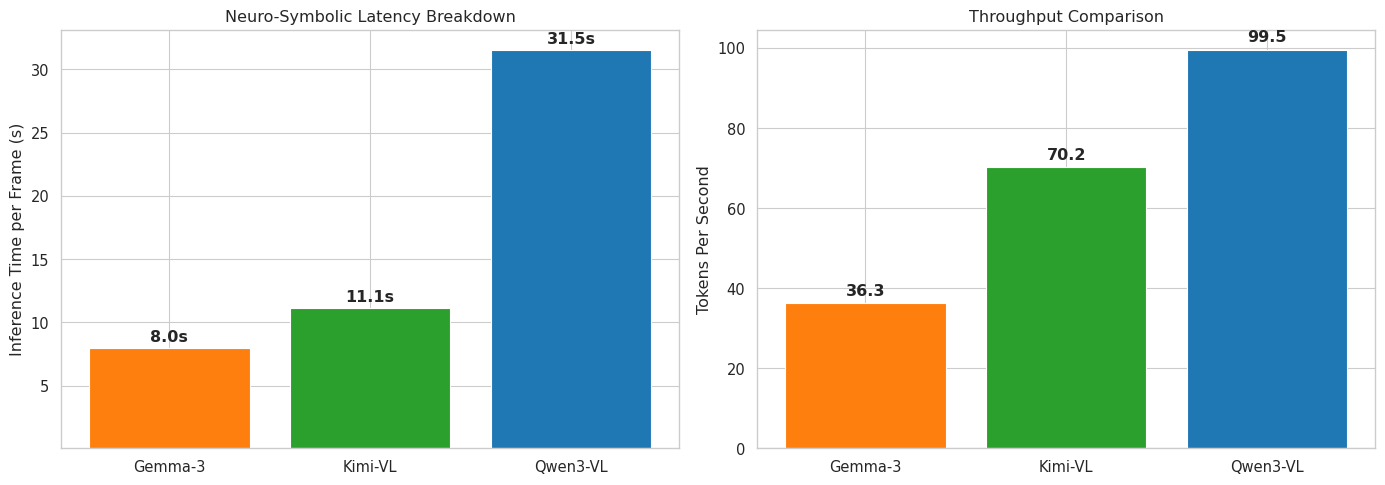

In [45]:
# Group by Model
eff_stats = df.groupby("CleanModel")[["Total Latency (s)", "VLM Latency (s)", "YOLO Latency (s)", "TPS"]].mean()
display(eff_stats.round(2))

# PLOT: 1x2 Figure - Stacked Bar Chart and TPS Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

models = eff_stats.index
yolo_times = eff_stats["YOLO Latency (s)"]
vlm_times = eff_stats["VLM Latency (s)"]

# Left: Stacked Bar Chart (YOLO vs VLM)
ax1.bar(models, vlm_times, bottom=yolo_times, color=[MODEL_PALETTE.get(m, "#333333") for m in models])
ax1.set_ylabel("Inference Time per Frame (s)")
ax1.set_title("Neuro-Symbolic Latency Breakdown")

# Add labels
for i, (m, v) in enumerate(zip(models, vlm_times + yolo_times)):
    ax1.text(i, v + 0.5, f"{v:.1f}s", ha='center', fontweight='bold')

# Right: TPS Comparison
ax2.bar(models, eff_stats["TPS"], color=[MODEL_PALETTE.get(m, "#333333") for m in models])
ax2.set_ylabel("Tokens Per Second")
ax2.set_title("Throughput Comparison")

# Add labels
for i, (m, tps) in enumerate(zip(models, eff_stats["TPS"])):
    ax2.text(i, tps + 2, f"{tps:.1f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig("../assets/figures/latency_breakdown.pdf")
plt.show()

### 3. Reasoning Depth (Token Economics)
This is a proxy for "Thinking." Models with higher output tokens are generally performing deeper Chain-of-Thought (CoT).

/tmp/ipykernel_4078904/3601145803.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="CleanModel", y="Input Tokens", data=df, ax=ax_left, palette=MODEL_PALETTE, errorbar="sd", capsize=.1)


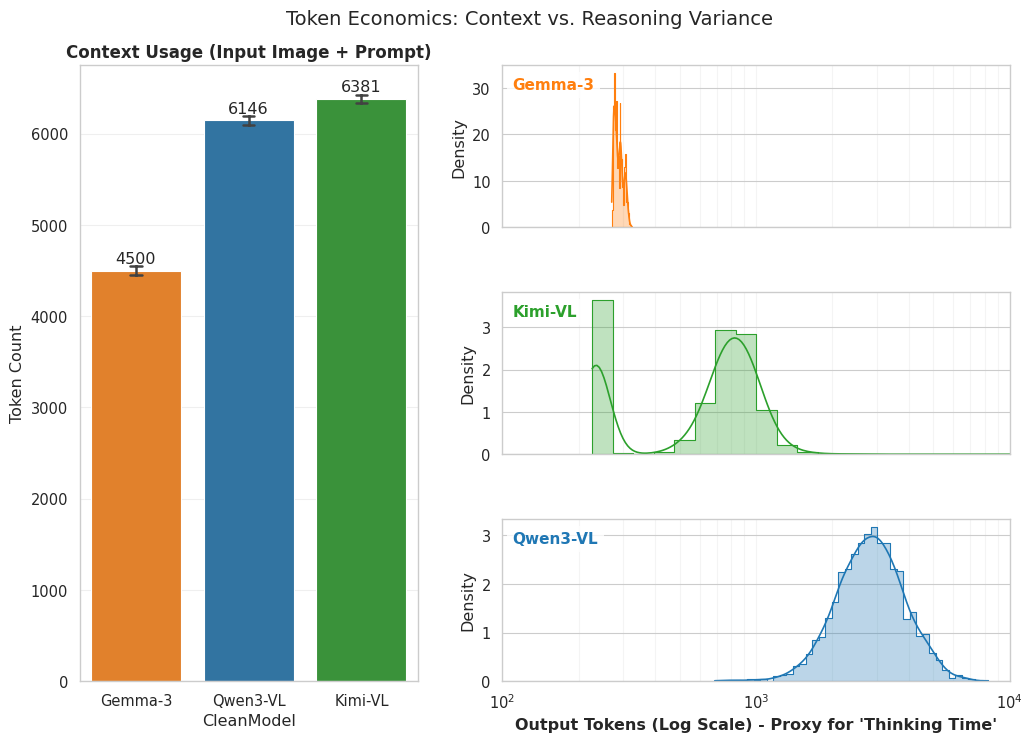

In [46]:
import matplotlib.gridspec as gridspec

# Create a custom Grid Layout
# 1 Column on Left (Input), 3 Rows on Right (Output distributions)
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(3, 2, width_ratios=[0.8, 1.2], wspace=0.2, hspace=0.4)

# --- LEFT PLOT: INPUT TOKENS (Context) ---
# Spans all 3 rows
ax_left = fig.add_subplot(gs[:, 0])
sns.barplot(x="CleanModel", y="Input Tokens", data=df, ax=ax_left, palette=MODEL_PALETTE, errorbar="sd", capsize=.1)

ax_left.set_title("Context Usage (Input Image + Prompt)", fontweight='bold', fontsize=12)
ax_left.set_ylabel("Token Count")
ax_left.grid(axis='y', alpha=0.3)

# Add value labels
for container in ax_left.containers:
    ax_left.bar_label(container, fmt='%.0f', padding=3)


# --- RIGHT PLOTS: OUTPUT TOKENS (Reasoning Depth) ---
# Stacked Subplots per Model
unique_models = sorted(df['CleanModel'].unique())
axes_right = []

for i, model in enumerate(unique_models):
    ax = fig.add_subplot(gs[i, 1])
    axes_right.append(ax)
    
    # Filter Data
    subset = df[df['CleanModel'] == model]
    color = MODEL_PALETTE.get(model, "#333")
    
    # Plot: Histogram with KDE, Log Scale on X
    # log_scale=True handles the wide variance nicely
    sns.histplot(
        data=subset, 
        x="Output Tokens", 
        ax=ax, 
        color=color, 
        kde=True, 
        element="step", 
        fill=True, 
        alpha=0.3,
        log_scale=True,
        stat="density",
        discrete=False
    )
    
    # Customizing the Subplot
    # We put the Title INSIDE the plot to save space
    ax.text(0.02, 0.85, f"{model}", transform=ax.transAxes, 
            fontweight='bold', color=color, fontsize=11, 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    ax.set_ylabel("Density")
    ax.grid(axis='x', which='both', alpha=0.2)
    
    ax.set_xlim(100, 10000)
    
    # Only show X-label on the bottom plot
    if i < len(unique_models) - 1:
        ax.set_xlabel("")
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Output Tokens (Log Scale) - Proxy for 'Thinking Time'", fontweight='bold')

plt.suptitle("Token Economics: Context vs. Reasoning Variance", fontsize=14, y=0.95)
plt.savefig("../assets/figures/token_economics_detailed.pdf")
plt.show()

### 4. Criticality Analysis (Risk Scoring)
Do models agree on what is dangerous? A spread here indicates potential bias.

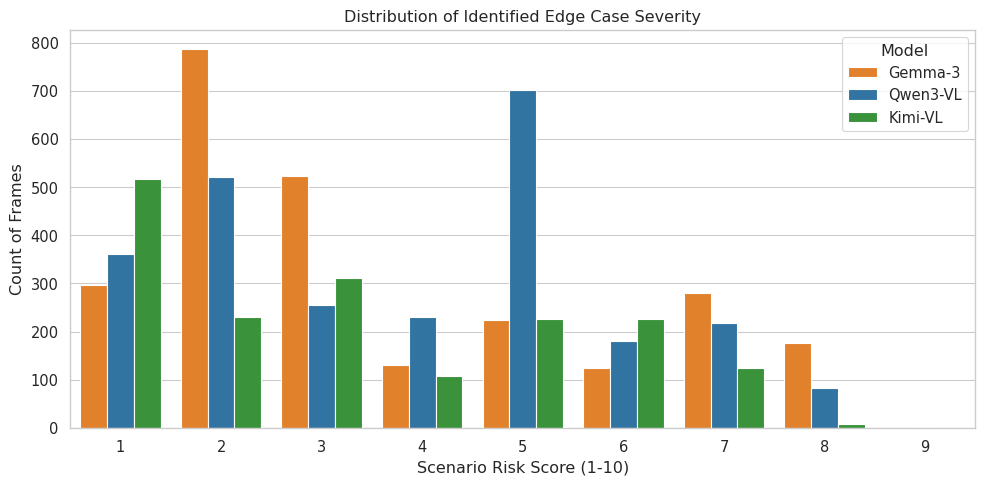

In [48]:
plt.figure(figsize=(10, 5))

# Filter for non-zero risks to see the distribution of DETECTED hazards
risk_df = df[df["Risk Score"] > 0]

sns.countplot(x="Risk Score", hue="CleanModel", data=risk_df, palette=MODEL_PALETTE)

plt.title("Distribution of Identified Edge Case Severity")
plt.xlabel("Scenario Risk Score (1-10)")
plt.ylabel("Count of Frames")
plt.legend(title="Model")

plt.tight_layout()
plt.savefig("../assets/figures/risk_distribution.pdf")
plt.show()

### 5. Correlation Analysis: Does "Thinking More" = "Higher Risk"?
Testing the hypothesis that complex scenarios require longer reasoning traces.

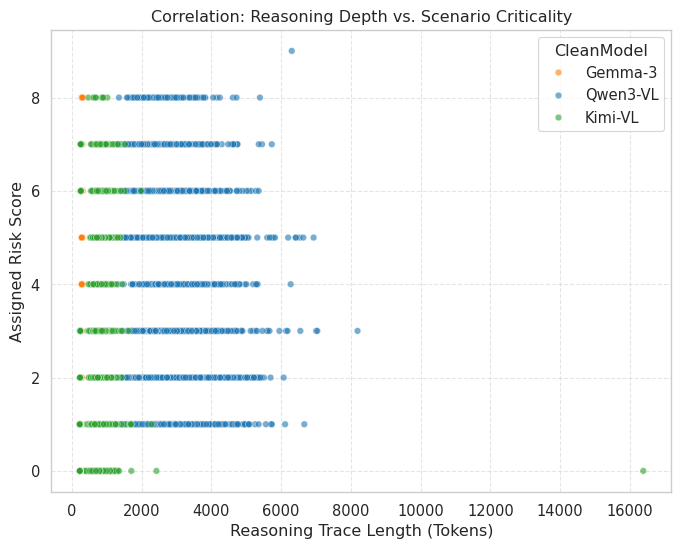

In [49]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=df, 
    x="Output Tokens", 
    y="Risk Score", 
    hue="CleanModel", 
    alpha=0.6, 
    palette=MODEL_PALETTE
)

plt.title("Correlation: Reasoning Depth vs. Scenario Criticality")
plt.xlabel("Reasoning Trace Length (Tokens)")
plt.ylabel("Assigned Risk Score")
plt.grid(True, linestyle="--", alpha=0.5)

plt.savefig("../assets/figures/reasoning_vs_risk.pdf")
plt.show()